<a href="https://colab.research.google.com/github/Tony6512/Particle-Method/blob/main/Particle_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a part of my work in my dissertation, Approximation and Incompressible Limit of Porous Medium, at Michigan State University (https://d.lib.msu.edu/etd/programs/Mathematics). We follow a similar particle method as used in https://arxiv.org/abs/2202.12927 and https://arxiv.org/abs/1709.09195. Some of the code here is inspired by https://zenodo.org/records/3961198.  

In this notebook, we develop a particle method to approximate solutions of a weighted porous medium equation with aggregation/interaction and drift.  

---





We study the weighted porous media equation
\begin{align}
    \partial _t \mu = \nabla \cdot \left ( \frac{a}{2} \nabla \left ( \frac{\mu ^2}{a^2} \right ) \right ) + \nabla \cdot ( \mu \nabla (V+ V_k)) + \nabla \cdot ( \mu (\nabla W \ast \mu) )
    \tag{WPME}
\end{align}
by using Wasserstein gradient flow theory. New numercial methods have come from gradient flow theory, namely deterministic particle method. The particle method involves discretizing the initial data $\mu _0 = \mu (0)$ as a finite sum of Dirac masses. Using the fact that $\mu$ is the gradient flow of the energy corresponding to WPME and it solves WPME in the weak sense, we obtain a system of ODEs for the particles.  As the number of particles, $N$, gets large, the discrete measure converges to a solution of the PME that preserves the gradient flow structure. Note that as the diffusion smooths out the particles so that they are no longer particles; a regularization is required.

We will generalize this particle method by adding an aggregation term and more importantly generalizing the convexity property of the energy so that $\omega$-convexity is sufficient rather than semi-convexity (or $\lambda$-convexity).

Note that the first term on the right hand-side is the diffusion that spreads out the mass. The second term is the drift/transport. In particular, $V_k$ is the confinement that constraints the particles to $\Omega$. The third term is the aggregation/interaction. Depending on the sign, it can be attractive or repulsive.

# Import modules and set up widgets

You only need to run this section after opening the notebook. Once you run this section, you do not need to rerun this section unless you restart the sesstion or add new (or customize the) widgets.

In [ ]:
pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import pandas as pd
import seaborn as sns
import sympy
import math
from IPython.display import display, HTML, Math
import time

In [ ]:
style = {'description_width': 'initial'}
N_slider = widgets.IntSlider(
    value=100,
    min=50,
    max=200,
    step=10,
    description='Number of Particles',
    style = style,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
k_slider = widgets.FloatLogSlider(
    value=100,
    base=10,
    min=1, # max exponent of base
    max=10, # min exponent of base
    step=1.0, # exponent step
    description='Confinement'
)
interaction_type_slider =  widgets.Dropdown(
    options=['Newtonian', 'Bessel'],
    value='Newtonian',
    description='Aggregation Kernel:',
    style = style,
    disabled=False,
)
agg_sign_slider = widgets.Dropdown(
    options=[('Attractive', 1), ('Repulsive', -1)],
    value=1,
    description='if Newtonian',
)
distribution_slider = widgets.Dropdown(
    options=['uniform', 'piece-wise', 'log-concave'],
    value='uniform',
    description='Target Distribution',
    style = style,
    disabled=False,
)
initial_data_slider = widgets.Dropdown(
    options=['Barenblatt', 'piece-wise', 'uniform', 'cosine', 'polynomial'],
    value='Barenblatt',
    description='Initial Data',
    style = style,
    disabled=False,
)
add_diff_term_slider = widgets.Dropdown(
    options=[('Yes', 1), ('No', 0)],
    value=1,
    description='Add Diffusion?',
    style = style,
)
add_interaction_term_slider = widgets.Dropdown(
    options=[('Yes', 1), ('No', 0)],
    value=0,
    description='Add Aggregation?',
    style = style,
)
add_drift_term_slider = widgets.Dropdown(
    options=[('Yes', 1), ('No', 0)],
    value=0,
    description='Add Drift?',
    style = style,
)

# Define Parameters

Here is the cell where we can change the variables we want such as the number of particles ($N$) or the target distribution (distribution). We can also choose whether we want to include any or all of the diffusion, aggregation, and drift. For example, to add the diffusion term, we set add_diff_term = 1 (this means True). There is a printout of some of the variables to keep track of the values of the variables for the current run.

If you prefer, then you can ignore the immediate cell below and define the parameters via the widgets.



In [ ]:
### initialize values (number or robots/particles, confinement strength, target distribution)
### the number of particles
N = 100 ## N = 20 , 50, 70, 100, 150,200
epsilon = 4/N**0.99
### the strength of confinement
k = 100 ## k = 10, 100, 1e4, 1e9
### max_step in ode solver + start and end time
max_step = 10**(-2) ## max_step = 10**(-2) - 10**(-5)
start_time = 0
end_time = 1
d = 1 ## dimension (only works for d=1 at the moment)
### coefficients of the diffusion and aggregation
diff_coef = 1
agg_coef = 1
### Sign of aggregation
agg_sign = 1 ## For aggregation, sign = 1 attractive, sign = -1 repulsive
mollifier_type = 'Gaussian'
## initial_data = 'Barenblatt', 'piece-wise', 'uniform', 'cosine', 'polynomial'
initial_data = 'Barenblatt'
### target distrubtion
## distribution ='uniform', 'piece-wise', 'log-concave'
distribution = 'uniform'

# add_diffusion_term = 0 ## 'no'
add_diffusion_term = 1 ## 'yes'

add_drift_term = 0 ## 'no'
# add_drift_term = 1 ## 'yes'

add_interaction_term = 0 ## 'no'
# add_interaction_term = 1 ## 'yes'

interaction_type = 'Newtonian' ## interaction_type = 'Newtonian', "Bessel"

if add_diffusion_term:
  print('diffusion term included')
if add_drift_term:
  print('drift term included')
if add_interaction_term:
  if interaction_type == 'Newtonian':
    if agg_sign == 1:
      print(f'interaction term included (Attractive {interaction_type})')
    elif agg_sign == -1:
      print(f'interaction term included (Replusive {interaction_type})')
    else:
      print(f'interaction term included ({interaction_type})')
  else:
    print(f'interaction term included ({interaction_type})')

print(f'N = {N}, k = {k}, epsilon = {epsilon:0.5f}, max_step = {max_step}, end_time = {end_time}')
print(f'distribution = {distribution}, initial data = {initial_data}, \
diff coef = {diff_coef}, agg sign = {agg_sign}, mollifier = {mollifier_type}')

diffusion term included
N = 100, k = 100, epsilon = 0.04189, max_step = 0.01, end_time = 1
distribution = uniform, initial data = Barenblatt, diff coef = 1, agg sign = 1, mollifier = Gaussian


If you decide to use the widgets to choose the parameter values, then go ahead and do so.

In [ ]:
box = widgets.VBox([N_slider,k_slider,distribution_slider,initial_data_slider,
                    add_diff_term_slider, add_drift_term_slider,add_interaction_term_slider,
                    interaction_type_slider,agg_sign_slider])

display(box)

After you are satisfied with the parameters you chose, run the next section.

# Initialize Values for Widgets

Run this section only if you are using the widgets to select the parameter values.
Run the previous section before this section. Do not run them concurrently/simultanously. Confirm the values you chose (via widgets) are printed below. If not, then rerun the widget (last section) and then rerun this section.



In [ ]:
### initialize values (number or robots/particles, confinement strength, target distribution)
### the number of particles
N = N_slider.value ## N = 20 , 50, 70, 100, 200
epsilon = 4/N**0.99
### the strength of confinement
k = k_slider.value ## k = 10, 100, 1e4, 1e9
### max_step in ode solver + start and end time
max_step = 10**(-2) ## max_step = 10**(-2) - 10**(-5)
start_time = 0
end_time = 1
d = 1 ## dimension (only works for d=1 at the moment)
### coefficients of the diffusion and aggregation
diff_coef = 1
agg_coef = 1
### Sign of aggregation
agg_sign = agg_sign_slider.value ## For aggregation, sign = 1 attractive, sign = -1 repulsive
mollifier_type = 'Gaussian'
## initial_data = 'Barenblatt', 'piece-wise', 'uniform', 'cosine', 'polynomial'
initial_data = initial_data_slider.value
### target distrubtion
## distribution ='uniform', 'piece-wise', 'log-concave'
distribution = distribution_slider.value

add_diffusion_term = add_diff_term_slider.value ## 1 means 'yes' and 0 mean 'no'
add_drift_term = add_drift_term_slider.value ## 1 means 'yes' and 0 mean 'no'
add_interaction_term = add_interaction_term_slider.value ## 1 means 'yes' and 0 mean 'no'

interaction_type = interaction_type_slider.value ## interaction_type = 'Newtonian', "Bessel"

print('Using sliders values.')
if add_diffusion_term:
  print('diffusion term included')
if add_drift_term:
  print('drift term included')
if add_interaction_term:
  if interaction_type == 'Newtonian':
    if agg_sign == 1:
      print(f'interaction term included (Attractive {interaction_type})')
    elif agg_sign == -1:
      print(f'interaction term included (Replusive {interaction_type})')
    else:
      print(f'interaction term included ({interaction_type})')
  else:
    print(f'interaction term included ({interaction_type})')

print(f'N = {N}, k = {k}, epsilon = {epsilon:0.5f}, max_step = {max_step}, end_time = {end_time}')
print(f'distribution = {distribution}, initial data = {initial_data}, \
diff coef = {diff_coef}, agg sign = {agg_sign}, mollifier = {mollifier_type}')

Using sliders values.
diffusion term included
N = 100, k = 100.0, epsilon = 0.04189, max_step = 0.01, end_time = 1
distribution = uniform, initial data = Barenblatt, diff coef = 1, agg sign = 1, mollifier = Gaussian


# Approximating Solution to WPME

## Intro / Set up

We create the region $\Omega$ that contains $N$ internals. Each of the $N$ initial particles locations are going to be initialized at the middle of $N^{\text{th}}$ interval, respectively. We give the particles mass based on the initial condition of the solution.

In [ ]:
## create region, initial particles locations,
omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
volume = omega[-1] - omega[0]
h = volume / N
X_0 = (omega[1:] + omega[:-1]) / 2

## initial condition
coef_array = [1, 0,0,0, -1]
def psi(x, initial_data = initial_data, coef_array = coef_array,tau = 0.0625):
  """The initial condition given initial data. Gives mass to particles based on
  distribution.

  Parameters
  ----------
  x: list
    Particle locations
  initial_data: str, optional
    Distribution of initial data
  coef_array: list
    List of coeficients of polynomial (if initial_data == 'polynomial')
  tau: float
    Scalar parameter in Barenblatt profile

  Returns
  -------
  list
    list of floats

  """
  if initial_data == 'Barenblatt':
    return (tau**(-1/3) / 12)* max( 3 **(4/3) - abs(x)**2 / tau**(2/3), 0)
  elif initial_data == 'piece-wise':
    if (-0.75 <= x and x < -0.25 ) or (0.25 <= x and x < 0.75):
      return 2/3
    else:
      return 1/3
  elif initial_data == 'uniform':
    return 1/2
  elif initial_data == 'cosine':
    p = np.cos(10*x) +2
    modulus =  np.sum(p)
    return p / (h*modulus)
  elif initial_data == 'polynomial':
    ## coef_array = [1,2,3] -> p = 1 + 2*x + 3*x**2
    p = np.polynomial.Polynomial(coef_array)(x)
    modulus =  np.sum(p)
    return p / (h*modulus)


if initial_data == 'piece-wise' or initial_data == 'uniform' or initial_data == 'Barenblatt':
  psi = np.vectorize(psi)

## give mass to particles
rho_0 = psi(X_0)
m = h*rho_0

Here we define the mollifer. In this work we deal only with the Gaussian, but this can be changed if desired. We define the integrand $V$ for the drift and $W$ for the aggrgation. In particular, the aggregation/interaction is either defined with the Newtonian kernel or the Bessel kernel. The Bessel kernel tends to run much slower due to an extra integration.

In [ ]:
def mollifier(x, epsilon): ## Gaussian
  """Generates the Gaussian mollifier.

  Parameters
  ----------
  x: list
    particle locations
  epsilon: float
    limiting variable for approximation

  Returns
  -------
  list
    list of scalars that are values of the Gaussian


  """
  return np.exp(-x**2 / (2*epsilon**2) ) / np.sqrt(2*np.pi*epsilon**2)

In [ ]:
def V(x):
  """The integrand of the potential/drift energy.

  Parameters
  ----------
  x: list
    Particle locations

  Returns
  -------
  list
    list of floats

  """
  V = x**2 / 2
  return V

For reference to Newtonian and Bessel kernels see https://arxiv.org/abs/1203.3573 and https://arxiv.org/abs/1003.4182.

In [ ]:
def Newtonian(x,d = 1): ## kernel for  - \Delta v = u (notice negative)
  """The Newtonian function for the aggregation/interaction energy.

  Parameters
  ----------
  x: list
    Particle locations
  d: float
    dimension (default is 1)

  Returns
  -------
  list
    list of floats

  """
  if d != 2:
    w_d = np.pi **(d/2) / math.gamma( d/2 +1)
    return ( abs(x)**(2-d) /  (d*(d-2)*w_d)  )
  elif d == 2:
    return - np.log(abs(x)) / (2*np.pi)

In [ ]:
def Bessel_integrand(s , x, a, d):
  """The Bessel inegrand for the Bessel function. Used only in Bessel function.

  Parameters
  ----------
  s: dummy variable
  x: list
    Particle locations
  a: float
    alpha parameter in Bessel function
  d: float
    dimension

  Returns
  -------
  list
    list of floats

  """
  return np.exp(- abs(x)**2 / (4*s) - a*s) / (4*np.pi*s)**(d/2)

In [ ]:
def W(x, a = 1, d = 1, sign = agg_sign, interaction_type = interaction_type):
  """Kernel for aggregation/interaction energy.

  Parameters
  ----------
  x: list
    Particle locations
  a: float, optional
    alpha parameter in Bessel function (default is 1)
  d: float, optional
    dimension (default is 1)
  sign: float, optional
    Sign of aggregation. 1 represents attraction and -1 represents repulsion.
  interaction_type: string
    There are two options: Newtonian (default) and Bessel

  Returns
  -------
  list
    list of floats

  """
  ### Newtonian
  if interaction_type == 'Newtonian':
    W = Newtonian(x, d)
  ### Bessel
  elif interaction_type == 'Bessel':
    s = np.linspace(0.001, 50, 4000) ## time
    s = s.reshape(-1,1, 1, 1) ## this is b/c input shape is x.shape = (len(x_span), N, 1)
    W = scipy.integrate.simpson(Bessel_integrand(s, x, a, d) , x = s.flatten(), axis = 0)
  return W * sign

We define the weight ($a(x)$ in the pde above). When there is no drift or aggregation/interaction ($V=W=0$), then $a(x)$ is the steady-state (or target) and will be plotted. As the input to the weight is a vector, the weight needs to be vectorized in some situations. One example is when the distribution = 'piece-wise' as conditional statement of a vector is ambiguous.

In [ ]:
## weight
def weight(b, distribution = distribution):
  """The weight or inhomogeneity of the porous medium equation (PME).

  Parameters
  ----------
  b: list
    Particle locations
  distribution: string, optional
    String of which weight distribution is desired (default distribution).

  Returns
  -------
  list
    list of floats

  """
  if distribution == 'uniform':
    return 1/2
  elif distribution == 'piece-wise':
    if (-0.75 <= b and b < -0.25 ) or (0.25 <= b and b < 0.75):
      return 2/3
    else:
      return 1/3
  elif distribution == 'log-concave':
    C_rho_bar = 2 / np.pi
    return  C_rho_bar /  (1 + abs(b)**2)



if distribution == 'piece-wise' or distribution == 'uniform':
  weight = np.vectorize(weight)


def target(x):
  """The target function. This is the steady state if V=W=0 and is only called
   in that case.

  Parameters
  ----------
  x: list
    Particle locations

  Returns
  -------
  list
    list of floats

  """
  if not add_drift_term and not add_interaction_term:
    return weight(x)


For the ODE, we define the the derivative of the confinement below. It is done in this way to be efficient.

In [ ]:
def DVk_where(x,k):
  """The derivative of the confinement function.

  Parameters
  ----------
  x: list
    Particle locations
  k: float
    The strength of confinement.

  Returns
  -------
  list
    list of floats

  """
  result = np.zeros(x.shape)
  greater1 = np.where(x > 1)
  lessneg1 = np.where(x < -1)
  result[greater1] = k*(x[greater1]-1)
  result[lessneg1] = k*(x[lessneg1]+1)
  return result

## Graphs of functions, target, initial data

We plot the functions here if they are included.




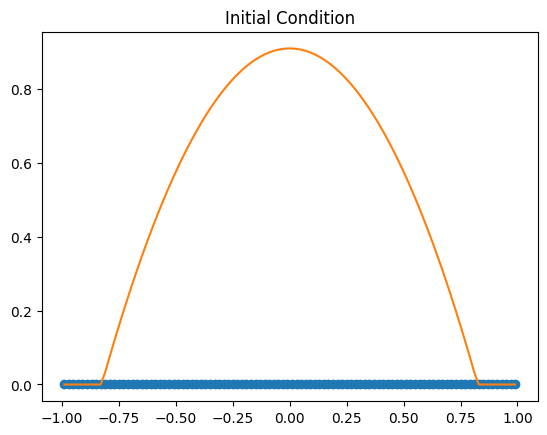

In [ ]:
plt.plot(X_0, np.zeros(X_0.shape), 'o')
plt.plot(X_0, rho_0,'-')
plt.title('Initial Condition')
None

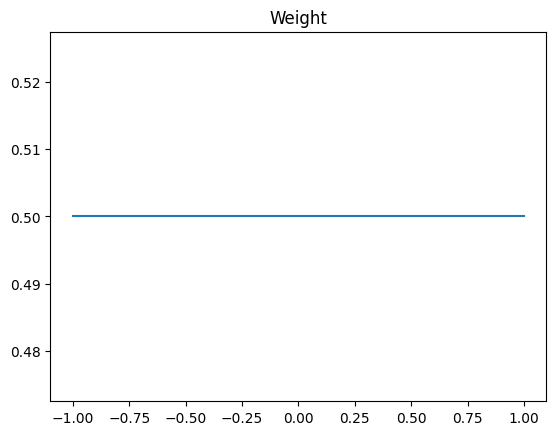

In [ ]:
plt.plot(omega, weight(omega))
plt.title('Weight')
plt.show()
None

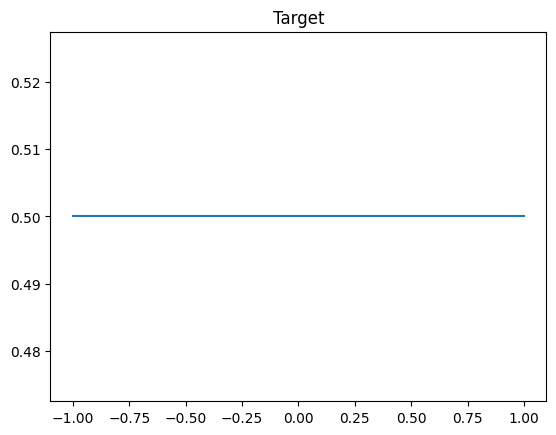

In [ ]:
## target measure plot
if not add_drift_term and not add_interaction_term:
  plt.plot(omega, target(omega))
  plt.title('Target')
  plt.show()
  None

In [ ]:
if add_interaction_term:
  plt.plot(omega, W(omega))
  plt.title('W')
  plt.show()
  None

In [ ]:
if add_drift_term:
  plt.plot(omega, V(omega))
  plt.title('V')
  plt.show()
  None

## Defining the mollifier

We use the symbolic library, sympy, to define the mollifier. This allows us to take a derivative symbolically instead of manually. This allows easier change of the mollifier in the future. The lambdify method is used so that the mollifier can be evaluated numerically.

In [ ]:
## symbolic functions via sympy
x_sym, xi_sym, epsilon_sym = sympy.symbols('x x_i epsilon')
mollifier_sym_one = sympy.exp(- x_sym**2 / (2*epsilon_sym**2) ) / sympy.sqrt(2*sympy.pi*epsilon_sym**2)
mollifier_sym = mollifier_sym_one.subs(x_sym, x_sym - xi_sym)
display(mollifier_sym)

sqrt(2)*exp(-(x - x_i)**2/(2*epsilon**2))/(2*sqrt(pi)*sqrt(epsilon**2))

In [ ]:
## convert to use with numpy arrays
mollifier_np = sympy.lambdify((x_sym, xi_sym, epsilon_sym), mollifier_sym, modules="numpy")
## derivative of mollifier
derv_moll_sym_one = sympy.diff(mollifier_sym_one, x_sym)
derv_moll_sym = derv_moll_sym_one.subs(x_sym, x_sym - xi_sym)
derv_moll_np = sympy.lambdify((x_sym, xi_sym, epsilon_sym), derv_moll_sym, modules="numpy")
display(derv_moll_sym)

-sqrt(2)*(x - x_i)*exp(-(x - x_i)**2/(2*epsilon**2))/(2*sqrt(pi)*epsilon**2*sqrt(epsilon**2))

It can be shown that the convolution of two Gaussians is Gaussian via Fourier transform. To reduce computational cost, we use this fact to save us from computing a needless convolution.  

In [ ]:
## phi_e  = zeta_e * zeta_e, proof follows from fourier transform
phi_sym = sympy.exp(- x_sym**2 / (4*epsilon_sym**2) ) / (sympy.sqrt(4*sympy.pi*epsilon_sym**2))**d
phi_np = sympy.lambdify((x_sym, epsilon_sym), phi_sym, modules = "numpy")
def phi_e(x, epsilon = epsilon):
  return phi_np(x, epsilon)
der_phi_sym = sympy.diff(phi_sym, x_sym)
der_phi_np = sympy.lambdify((x_sym, epsilon_sym), der_phi_sym, modules="numpy")
def der_phi_e(x, epsilon = epsilon):
  return der_phi_np(x, epsilon)

To compute the convolution, we integrate using the simpson rule in scipy. Though we can compute on $\mathbb{R^d}$, we can save some computation cost by using Chebyshev's inequality or using the information of the mollifier. When the mollifier is a Gaussian, then 99.7% of the data lies within 3 standard deviations from the mean. If a different mollifier is used, then 3 could be as big as 10 by Chebyshev inequality (https://en.wikipedia.org/wiki/Chebyshev%27s_inequality#Probabilistic_statement).

In [ ]:
x_span = np.linspace(-1 - 3*epsilon, 1 + 3*epsilon, 200+1) ## 3 standard deviations for Gaussian

We use the reshape method to ensure that the region of integration is of the correct shape when defining the ODE. See a later section for more details.

In [ ]:
## reshape arrays to avoid loops
m_1d = np.atleast_2d(m).reshape(-1,1)
z = x_span.copy()
R_3d = np.atleast_2d(z).reshape(-1,1,1,1)
R_2d = np.atleast_2d(z).reshape(-1,1,1)
R_1d = np.atleast_2d(z).reshape(-1,1)

## Defining the ODE

After mollifying the gradient flow, the regularized PDE is
\begin{align*}
    \partial _t \mu = \nabla \cdot \left (   \mu \left (\nabla \zeta_\epsilon \ast \left (\frac{\zeta_\epsilon \ast \mu}{a}\right ) \right ) + \mu (\nabla \zeta _\epsilon \ast V) + \mu (\nabla \zeta _\epsilon \ast \zeta _\epsilon \ast W \ast \mu) + \mu \nabla V_k   \right ).
\end{align*}
Given that the gradient flow of $\mathcal{F}_\epsilon$ solves the above PDE in the weak sense, we can discretize the problem by letting
\begin{align*}
    \mu (t) = \sum _{i = 1} ^N \delta _{X^i (t) } m^i, \quad
    \mu_0 = \sum _{i = 1} ^N \delta _{X^i _0 } m^i, \quad
    \sum _{i = 1} ^N m^i = 1,
\end{align*}
where $\{ X^i(t) \} _{i = 1} ^N$ are the location of the particles. We then obtain a system of ODEs for the particle,
\begin{align*}
    \dot{X}^i (t) = - \sum _{j = 1} ^ N f(X^i, X^j) m^j - \nabla \zeta _\epsilon \ast V(X^i) - \nabla V_k(X^i) - \sum _{j = 1} ^ N m^j \nabla \zeta_\epsilon \ast \zeta_\epsilon \ast W(X^i - X^j)
\end{align*}
with $X^i (0) = X^i_0$
where
\begin{align*}
    f(X^i, X^j) = \int _{R^d} \frac{\nabla \zeta _\epsilon (X^i - z) \zeta _\epsilon (X^j - z)}{a(z)}\ dz .
\end{align*}

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, agg_coef = agg_coef):
  """Aggregation/Interaction term in pde.

  Parameters
  ----------
  Xi: list
    Particle locations
  m: list
    weight/mass of particles. Should be 1-dimensional.
  z: list
    Region in 3-dimensional list.
  y: list
    Region in 2-dimensional list.
  agg_coef: float
    Coefficient of aggregation term. This determines the strength of the
    aggregation.

  Returns
  -------
  list
    list of floats

  """
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)
          * mollifier_np(z,y, epsilon) *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  return - np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d):
  """Drift/transport term in pde.

  Parameters
  ----------
  Xi: list
    Particle locations
  z: list
    Region in 1-dimensional list.

  Returns
  -------
  list
    list of floats

  """
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef):
  """Diffusion term in pde.

  Parameters
  ----------
  Xi: list
    Particle locations
  m: list
    weight/mass of particles. Should be 1-dimensional.
  z: list
    Region in 2-dimensional list.
  diff_coef: float
    Coefficient of diffusion term. This determines the strength of the
    diffusion.

  Returns
  -------
  list
    list of floats

  """
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def particles(t,Xi):
  """ODE system.

  Parameters
  ----------
  t: dummy variable used for solve_ivp
  Xi: list
    Particle locations

  Returns
  -------
  list
    list of floats

  """
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi))
  return X_dot.ravel()

## ODE Solver, graphs

In [ ]:
## ODE solver
tic = time.perf_counter()
sol = scipy.integrate.solve_ivp(particles, [start_time, end_time], y0 = X_0,
                                method = 'BDF', max_step = max_step)
toc = time.perf_counter()
print(("Elapsed time: %.1f [sec]" % ((toc-tic))))
print(("Elapsed time: %.1f [min]" % ((toc-tic)/60)))

Elapsed time: 0.6 [sec]
Elapsed time: 0.0 [min]


In [ ]:
print(sol.y.shape)
print(sol.t.shape)

(100, 105)
(105,)


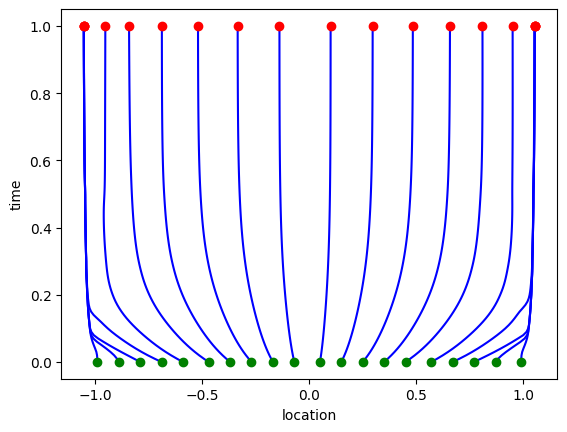

In [ ]:
## plot particle/robot paths
for i in np.linspace(0, sol.y.shape[0]-1, 20):
  i = int(i)
  plt.plot(sol.y[i], sol.t,'-b', label = f'particle {i}')
  plt.plot(sol.y[i, 0], sol.t[0], 'og')
  plt.plot(sol.y[i, -1], sol.t[-1], 'or')


plt.ylabel('time')
plt.xlabel('location')
# plt.title(f'{distribution} target, k = {k}')
#plt.legend()
plt.show()

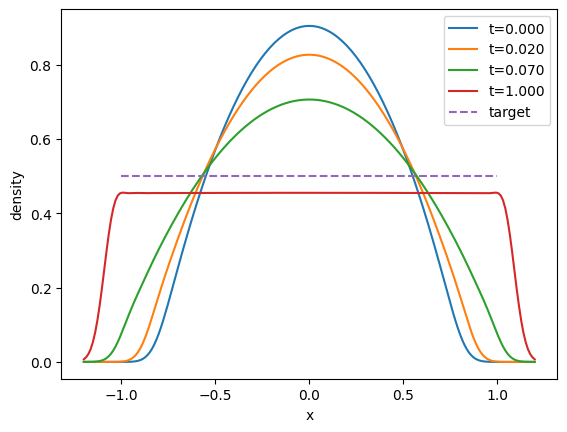

In [ ]:
## plot density at different times
eps_plt = 4/N**0.93 ### needed for plotting
x_span_plt = np.linspace(-1.2,1.2, 200)
for i in [0, sol.y.shape[1] // 20, sol.y.shape[1] // 10 ,sol.y.shape[1]-1]:
  i = int(i)
  rho = np.sum(m.reshape(1,-1)*mollifier_np(sol.y[:,i].reshape(1,-1),
                                             x_span_plt.reshape(-1,1),eps_plt), axis = 1)
  plt.plot(x_span_plt, rho,'-', label = f't={sol.t[i]:.3f}')


if not add_drift_term and not add_interaction_term:
  plt.plot(omega, target(omega), '--', label = 'target')

plt.ylabel('density')
plt.xlabel('x')
# plt.xlim(-1.2, 1.2)
# plt.ylim((0,1))
# plt.title(f'{distribution} target, N = {N}, k = {k}')
# plt.title(f'{distribution} target, N = {N}, k = {k}, diff coef = {diff_coef}')
plt.legend()
plt.show()

# Computational Complexity

## Velocity Law (ODE)

We plot the computation complexity (in time) of the ODE in terms of $N$. Notice that as $N$ is changing then so is $m$ (the mass distribution of the particles) and so $m$ is included as a keyword argument in the functions below.

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, s = -1, agg_coef = agg_coef , epsilon = epsilon):
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y, epsilon = epsilon) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)* mollifier_np(z,y, epsilon)
                   *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  return s*np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d, epsilon = epsilon):
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef, epsilon = epsilon):
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y, epsilon = epsilon) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def velocity_particles(t,Xi, m, epsilon = epsilon):
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m = m, epsilon = epsilon))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi, epsilon = epsilon))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m = m, epsilon = epsilon))
  return X_dot.ravel()  #X_dot.flatten()

In [ ]:
N_array = 10*2**np.arange(8)  ## array([  10,   20,   40,   80,  160,  320,  640, 1280])
# N_array = 5*10*np.arange(1,21,3)
v_times = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  rho_0 = psi(X_0) ## target at t = 0
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  tic = time.perf_counter()
  velocity_particles(t_0, X_0, m_1d)
  toc = time.perf_counter()
  v_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

Started: N = 10 (1/8)
Ended: N = 10 (1/8) with elapsed time 0.001 [sec]
Started: N = 20 (2/8)
Ended: N = 20 (2/8) with elapsed time 0.001 [sec]
Started: N = 40 (3/8)
Ended: N = 40 (3/8) with elapsed time 0.002 [sec]
Started: N = 80 (4/8)
Ended: N = 80 (4/8) with elapsed time 0.002 [sec]
Started: N = 160 (5/8)
Ended: N = 160 (5/8) with elapsed time 0.004 [sec]
Started: N = 320 (6/8)
Ended: N = 320 (6/8) with elapsed time 0.011 [sec]
Started: N = 640 (7/8)
Ended: N = 640 (7/8) with elapsed time 0.020 [sec]
Started: N = 1280 (8/8)
Ended: N = 1280 (8/8) with elapsed time 0.087 [sec]


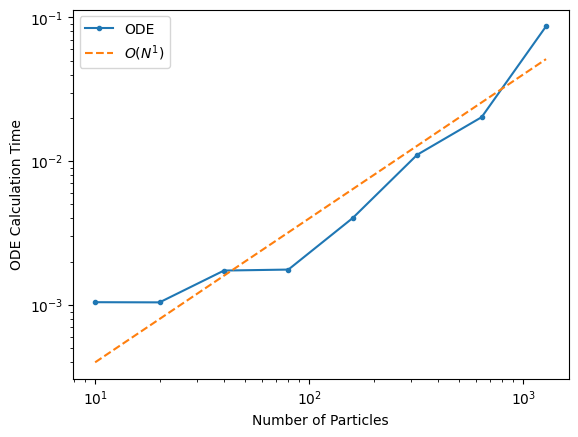

In [ ]:
plt.loglog(N_array, v_times, '.-', label = 'ODE')
plt.loglog(N_array, 5*1e-6*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 4*1e-5*N_array**1, '--', label = '$O(N^1)$')
plt.xlabel("Number of Particles")
plt.ylabel("ODE Calculation Time")
plt.legend()
plt.show()
None

Note that $\log(Cx^p) = p \log(x) + \log(C)$. So in the loglog plot, if you need to move the line up or down, then you can adjust the value of $C$ accordingly. If you need to change the slope of the line, then you adjust $p$.  

## Simulation

We can move on to the computational complexity of the simulation. This should only be an extra factor of $N$ from the complexity of the ODE. For that reason, I would recommend only running the ODE complexity cells and not the simluation complexity cells.

In [ ]:
# # ODE
def velocity_particles(t,Xi, m):
  Xi = np.atleast_2d(Xi)
  # diffusion = f_term(Xi, Xi.T)
  # X_dot = -(diffusion + DVk_where(Xi, k)  )
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m))
  return X_dot.ravel()  #X_dot.flatten()

In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
sim_times = [0]*len(N_array)
for j,N in enumerate(N_array):
  # epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  # t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  rho_0 = psi(X_0) ## target at t = 0
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  # velocity_particles(t_0, X_0, m_1d)
  start_time, end_time = 0 , 0.5
  t_span = np.linspace(start_time, end_time, 50)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  def wrapper(t,Xi):
    return velocity_particles(t,Xi, m = m_1d)
  tic = time.perf_counter()
  sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                  method = 'BDF')
  toc = time.perf_counter()
  sim_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

In [ ]:
plt.loglog(N_array, sim_times, '.-', label = 'Simulation')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
plt.xlabel("Number of Particles")
plt.ylabel("Simulation Calculation Time")
plt.legend()
plt.show()
None

# $L^1$ Error

To quantify the accuracy, we compute the $L^1$ errors relative to $N_{\text{max}}$.

In [ ]:
omega_fixed = np.linspace(-1,1,200)

In [ ]:
def L1_error(Xi, rho_max = [], epsilon = epsilon):
  rho_approx = np.sum(m.reshape(1,-1)*mollifier_np(Xi.reshape(1,-1), omega_fixed.reshape(-1,1),
        epsilon), axis = 1)
  if len(rho_max): ## hard code for large N
    rho_true = rho_max
  return scipy.integrate.simpson(np.abs(rho_approx - rho_true), x = omega_fixed, axis = 0)

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, s = -1, agg_coef = agg_coef , epsilon = epsilon):
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y, epsilon = epsilon) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)* mollifier_np(z,y, epsilon)
                   *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  return s*np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d, epsilon = epsilon):
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef, epsilon = epsilon):
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y, epsilon = epsilon) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def velocity_particles(t,Xi, m, epsilon = epsilon):
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m = m, epsilon = epsilon))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi, epsilon = epsilon))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m = m, epsilon = epsilon))
  return X_dot.ravel()  #X_dot.flatten()

We first start by computing $\rho_{\text{max}}$. This is the solution we compare the numerical solutions with $N$ particles. Define $N_\text{max}$ below.


In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_max = 226
# sim_times = [0]*len(N_array)
# errors = [0]*len(N_array)
N = N_max
epsilon = 4/N**0.99
omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
X_0 = (omega[1:] + omega[:-1]) / 2
# t_0 = 0
volume = omega[-1] - omega[0]
h = volume / N
# rho_0 = vec_psi(X_0) ## target at t = 0
rho_0 = psi(X_0) ## target at t = 0
m = h*rho_0
m_1d = np.atleast_2d(m).reshape(-1,1)
# velocity_particles(t_0, X_0, m_1d)
start_time, end_time = 0 , 0.1
# t_span = np.linspace(start_time, end_time, 50)
def wrapper(t,Xi):
  return velocity_particles(t,Xi, m = m_1d)
tic = time.perf_counter()
sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                method = 'BDF', max_step = max_step)
# errors[j] = L1_error(sol.y[:,-1])
toc = time.perf_counter()
rho_max = np.sum(m.reshape(1,-1)*mollifier_np(sol.y[:,-1].reshape(1,-1),
                                              omega_fixed.reshape(-1,1), epsilon), axis = 1)
# sim_times[j] = toc - tic
print(f'Elapsed time {toc - tic:.3f} [sec]')

Elapsed time 74.468 [sec]


Now we compute the $L^1$  errors.

In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
# sim_times = [0]*len(N_array)
errors = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  # t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  # rho_0 = vec_psi(X_0) ## target at t = 0
  rho_0 = psi(X_0)
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  # velocity_particles(t_0, X_0, m_1d)
  start_time, end_time = 0 , 0.1
  # t_span = np.linspace(start_time, end_time, 50)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  def wrapper(t,Xi):
    return velocity_particles(t,Xi, m = m_1d, epsilon = epsilon)
  tic = time.perf_counter()
  sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                  method = 'BDF', max_step = max_step)
  errors[j] = L1_error(sol.y[:,-1], rho_max)
  toc = time.perf_counter()
  # sim_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

Started: N = 10 (1/8)
Ended: N = 10 (1/8) with elapsed time 0.036 [sec]
Started: N = 14 (2/8)
Ended: N = 14 (2/8) with elapsed time 0.053 [sec]
Started: N = 20 (3/8)
Ended: N = 20 (3/8) with elapsed time 0.125 [sec]
Started: N = 28 (4/8)
Ended: N = 28 (4/8) with elapsed time 0.252 [sec]
Started: N = 40 (5/8)
Ended: N = 40 (5/8) with elapsed time 0.655 [sec]
Started: N = 56 (6/8)
Ended: N = 56 (6/8) with elapsed time 1.515 [sec]
Started: N = 80 (7/8)
Ended: N = 80 (7/8) with elapsed time 1.690 [sec]
Started: N = 113 (8/8)
Ended: N = 113 (8/8) with elapsed time 10.250 [sec]


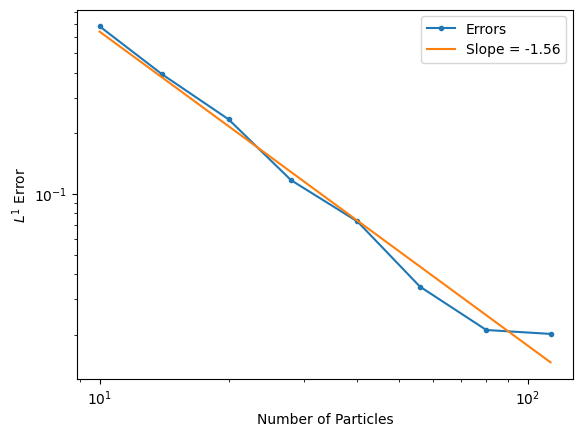

In [ ]:
plt.loglog(N_array, errors, '.-', label = 'Errors')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
slope, y_intercept = np.polyfit(np.log10(N_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(N_array, 10**y_intercept * N_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("Number of Particles")
plt.ylabel("$L^1$ Error")
plt.legend()
plt.show()
None

# Reducing Computational Cost

We can simplify the computation of ODE using knowledge of specific mollifier. We do this in the work above but explain it here.

For $k,N \in \mathbb{N} , \epsilon > 0 $, and $t\in [0,T]$, consider the evolving empirical measure,
    \begin{align*}
     \mu _{\epsilon,k}^N (t) = \sum _{i = 1} ^N \delta _{X^i _{\epsilon,k} (t) } m^i, \quad
    m^i \geq 0, \quad
    \sum _{i = 1} ^N m^i = 1,
    \end{align*}
    where
    $X^i _ {\epsilon , k}$
    solves,
    \begin{align*}
    \begin{cases}
         \dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \int _{R^d} \nabla \zeta _\epsilon (X^i_{\epsilon,k} - z) \zeta _\epsilon (X^j_{\epsilon,k} - z)\frac{1}{a(z)}\ dz
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \zeta_\epsilon \ast \zeta_\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) \\
         X^i _{\epsilon,k} (0) &= X^i _{0,\epsilon}.
    \end{cases}
    \end{align*}

Looking at the ODE (velocity law) above, we would expect that the drift is $O(N)$, the diffusion is $O(N^2)$, and the aggregation is $O(N^3)$. However, using properties of a specific mollifier, we can do better. Let us assume that the mollifier $\zeta _\epsilon$ is a Gaussian. Using the Fourier transform, one can show that the convolusion of two Gaussians is Gaussian. Namely, $\varphi _\epsilon = \zeta _\epsilon \ast \zeta _\epsilon$ is Gaussian. In particular, the mean is mean$_1$ + mean$_2$ and the variance is var$_1$ + var$_2$.

In [ ]:
def mollmoll(x, z = R_1d):
  # return h_R * np.sum(mollifier_np(x,z, epsilon) * mollifier_np(z, 0, epsilon), axis = 0)
  return scipy.integrate.simpson( mollifier_np(x,z, epsilon) * mollifier_np(z, 0, epsilon), x = x_span,axis = 0)

Instead of giving an explicit proof here, we compute the two and compare via a simple plot.

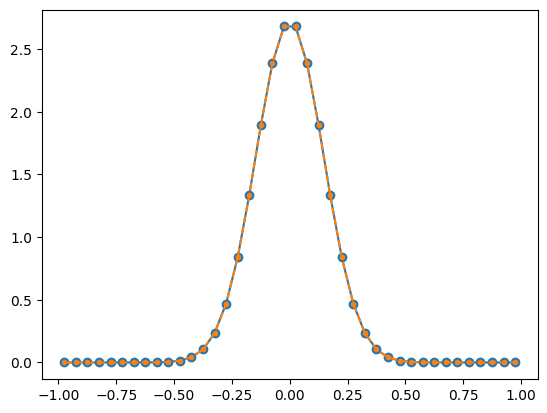

In [ ]:
## shows that phi_e is equivalent to mollmoll (phi_e less computation)
## convolving two Gaussians is still a Gaussian
X0_2d = np.atleast_2d(X_0)
plt.plot(X0_2d.T, mollmoll(X0_2d), 'o-')
plt.plot(X0_2d.T, phi_e(X0_2d.ravel()), '.--')
None

Thus, we can reduce the aggregation to $O(N^2)$,
\begin{align*}
\dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \int _{R^d} \nabla \zeta _\epsilon (X^i_{\epsilon,k} - z) \zeta _\epsilon (X^j_{\epsilon,k} - z)\frac{1}{a(z)}\ dz
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \varphi _\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) .
\end{align*}

If $a(z)$ is a scalar, then we can reduce the diffusion to $O(N)$,
\begin{align*}
\dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \frac{1}{a} \nabla \varphi_\epsilon ({X}^i _{\epsilon,k} - {X}^j _{\epsilon,k})
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \varphi _\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) .
\end{align*}

However, if the aggregation still remains, then the ODE is still $O(N^2)$. If we did have no aggregation ($W = 0$) and had only drift and diffusion (scalar weight), then the ODE would be $O(N)$,
\begin{align*}
\dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \frac{1}{a} \nabla \varphi_\epsilon ({X}^i _{\epsilon,k} - {X}^j _{\epsilon,k})
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) .
\end{align*}

# Broadcasting Example

We discuss an example using the interaction energy (with Gaussian mollifier). As the functions (mollifier and W) output shape are the same as the input shape, we will ignore the functions in the discussion below. The broadcasting techinques can be seen in this link.

https://numpy.org/doc/stable/user/basics.broadcasting.html

Let us start by establishing the initial particles locations.

In [ ]:
## create region, initial particles locations,
omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
volume = omega[-1] - omega[0]
h = volume / N
X_0 = (omega[1:] + omega[:-1]) / 2

In [ ]:
X_0

array([-0.99, -0.97, -0.95, -0.93, -0.91, -0.89, -0.87, -0.85, -0.83,
       -0.81, -0.79, -0.77, -0.75, -0.73, -0.71, -0.69, -0.67, -0.65,
       -0.63, -0.61, -0.59, -0.57, -0.55, -0.53, -0.51, -0.49, -0.47,
       -0.45, -0.43, -0.41, -0.39, -0.37, -0.35, -0.33, -0.31, -0.29,
       -0.27, -0.25, -0.23, -0.21, -0.19, -0.17, -0.15, -0.13, -0.11,
       -0.09, -0.07, -0.05, -0.03, -0.01,  0.01,  0.03,  0.05,  0.07,
        0.09,  0.11,  0.13,  0.15,  0.17,  0.19,  0.21,  0.23,  0.25,
        0.27,  0.29,  0.31,  0.33,  0.35,  0.37,  0.39,  0.41,  0.43,
        0.45,  0.47,  0.49,  0.51,  0.53,  0.55,  0.57,  0.59,  0.61,
        0.63,  0.65,  0.67,  0.69,  0.71,  0.73,  0.75,  0.77,  0.79,
        0.81,  0.83,  0.85,  0.87,  0.89,  0.91,  0.93,  0.95,  0.97,
        0.99])

In [ ]:
X = np.atleast_2d(X_0)
print(X)

[[-0.99 -0.97 -0.95 -0.93 -0.91 -0.89 -0.87 -0.85 -0.83 -0.81 -0.79 -0.77
  -0.75 -0.73 -0.71 -0.69 -0.67 -0.65 -0.63 -0.61 -0.59 -0.57 -0.55 -0.53
  -0.51 -0.49 -0.47 -0.45 -0.43 -0.41 -0.39 -0.37 -0.35 -0.33 -0.31 -0.29
  -0.27 -0.25 -0.23 -0.21 -0.19 -0.17 -0.15 -0.13 -0.11 -0.09 -0.07 -0.05
  -0.03 -0.01  0.01  0.03  0.05  0.07  0.09  0.11  0.13  0.15  0.17  0.19
   0.21  0.23  0.25  0.27  0.29  0.31  0.33  0.35  0.37  0.39  0.41  0.43
   0.45  0.47  0.49  0.51  0.53  0.55  0.57  0.59  0.61  0.63  0.65  0.67
   0.69  0.71  0.73  0.75  0.77  0.79  0.81  0.83  0.85  0.87  0.89  0.91
   0.93  0.95  0.97  0.99]]


We see that $X$ is a row vector with $N$ columns.

In [ ]:
X.shape  ## (1, N)

(1, 100)

We create the region in which we integrate over.

In [ ]:
M = 200 +1
x_span = np.linspace(-1 - 3*epsilon, 1 + 3*epsilon, M) ## 3 standard deviations for Gaussian

In [ ]:
## reshape arrays to avoid loops
m_1d = np.atleast_2d(m).reshape(-1,1)
z = x_span.copy()
R_3d = np.atleast_2d(z).reshape(-1,1,1,1)
R_2d = np.atleast_2d(z).reshape(-1,1,1)
R_1d = np.atleast_2d(z).reshape(-1,1)

In [ ]:
R_2d.shape  ## (M, 1, 1)

(201, 1, 1)

In [ ]:
R_2d[0:3]

array([[[-1.12565543]],

       [[-1.11439887]],

       [[-1.10314232]]])

Here we want to take each particle and subtract every point in the region $y^k$ for $k = 1, 2, \ldots , M$. To do so (without expensive for loops) we must reshape the region in the correct way.
\begin{align*}
\begin{pmatrix}
X^1 & X^2 & \cdots & X^N
\end{pmatrix}
-
\begin{pmatrix}
y ^1 \\
y^2 \\
\vdots \\
y^ M
\end{pmatrix}
\end{align*}

We take the $y$ vector and subtract with every $X^i$. Based on the shape of $y$ (the region) each vector can be thought of as a new slice in a cube.
\begin{align*}
\begin{pmatrix}
X^1 - y ^1 \\
X^1 - y^2 \\
\vdots \\
X^1 - y^ M
\end{pmatrix}
\begin{pmatrix}
X^2 - y ^1 \\
X^2 - y^2 \\
\vdots \\
X^2 - y^ M
\end{pmatrix}
⋯
\begin{pmatrix}
X^N - y ^1 \\
X^N - y^2 \\
\vdots \\
X^N - y^ M
\end{pmatrix}
\end{align*}


In [ ]:
(X - R_2d).shape  ## (M, 1, N)

(201, 1, 100)

Instead of computing $\sum _ i \sum _j X^ i - X^j$, we instead caluclate the equivalent $X - X^ T$ to be efficient.

Here we want to take each particle and subtract every point in the region. To do so (without expensive for loops) we must reshape the region in the correct way (the same shape as in the last calculation).
\begin{align*}
\begin{pmatrix}
y ^1 \\
y^2 \\
\vdots \\
y^ M
\end{pmatrix}
-
\begin{pmatrix}
X^1 \\
X^2 \\
\vdots \\
X^N
\end{pmatrix}
\end{align*}

Based on the shape of $y$ (the region) each vector is simply a new column.

\begin{align*}
\begin{pmatrix}
 y ^1 - X^1 &  y ^1 - X^2 & \cdots &  y ^1 - X^N \\
y ^2 - X^1 &  y ^2 - X^2 & \cdots &  y ^2 - X^N \\
\vdots  &                &         &   \vdots \\
y ^M - X^1 &  y ^M - X^2 & \cdots &  y ^M - X^N
\end{pmatrix}
\end{align*}


In [ ]:
(R_2d - X.T).shape ## (M, N, 1) or (len(x_span), N, 1)

(201, 100, 1)

Each slice of the cube is multiplied by every column in the above matrix.
For $i = 1,2,\ldots , N$
\begin{align*}
\begin{pmatrix}
X^i - y ^1 \\
X^i - y^2 \\
\vdots \\
X^i - y^ M
\end{pmatrix}
\cdot
\begin{pmatrix}
 y ^1 - X^1 &  y ^1 - X^2 & \cdots &  y ^1 - X^N \\
y ^2 - X^1 &  y ^2 - X^2 & \cdots &  y ^2 - X^N \\
\vdots  &                &         &   \vdots \\
y ^M - X^1 &  y ^M - X^2 & \cdots &  y ^M - X^N
\end{pmatrix}
\end{align*}
This is where each particle interacts with every other particle.

In [ ]:
( (X - R_2d) * (R_2d - X.T) ).shape  ## (M, N, N)

(201, 100, 100)

We now sum for the first axis (axis = 0) for the integration calculation leaving us with an $(N,N)$ matrix. Note that the first $N$ corresponds with the $j$ index and the second $N$ corresponds with the $i$ index. One may want to denote as $(N_j, N_i)$ to avoid confusion.
We multiply by the weight/mass $m$ (a column vector as it is a sum over $j$) so that we have
\begin{align*}
\begin{pmatrix}
m^1 \\
m^2 \\
\vdots \\
m^N
\end{pmatrix}
\cdot
\begin{pmatrix}
y - X^1   \\
y - X^2  \\
\vdots \\
y - X^N
\end{pmatrix}
\cdot
\begin{pmatrix}
X^1 - y &  X^2 - y & \cdots &  X^N - y \\
X^1 - y &  X^2 - y & \cdots &  X^N - y \\
\vdots  &                &         &   \vdots \\
X^1 - y &  X^2 - y & \cdots &  X^N - y \\
\end{pmatrix}
\end{align*}

We sum along the first axis (axis = 0). This is the $j = 1, 2, \ldots , N$ sum. This leaves us with a $(1,N)$ row vector (the same shape we started with). That is, particles $X^i$ for $i = 1, 2, \ldots , N$.


# End